# Task - Sample task with sample submission. Help us understand how geography affects virality.

### Task Details
What do we know about diagnostics and surveillance? What has been published concerning systematic, holistic approach to diagnostics (from the public health surveillance perspective to being able to predict clinical outcomes)?

# Following approach is designed to generate a Generic solution for NLP reserch task 
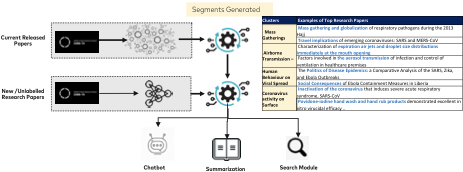
## Steps involved :- 

## Graph Clustering data creation
* ### Creation of Citation network graph:- [Base Files_extraction](https://www.kaggle.com/ashimak01/get-file-details)
* ### Extension of Graph network using cosine Similarity between abstract of reserch paper. ( Code will be available in GIT repo) .
    We used [BioSentVec](https://github.com/ncbi-nlp/BioSentVec) for this. Due to vec size , we ran this in Colab
    
* ### Combine Similarity and Citation Graph [Kernal for Join](https://www.kaggle.com/yatinece/combine-embedding-data-and-citations-article/data) 
* ### Running Ego split clustering to generate category/Clusters of reserch present [Kernal Code](https://www.kaggle.com/debasmitadas/unsupervised-clustering-covid-research-papers)

Once clusters were created we give name based on top keywords of reserch parpers , topic and search models


## Creating search to select best reserch papers to run NLP analysis on
* ### For every task and sub-task we generated multiple queries. Task-SubTask Query Mapping [Subtask-Query-Data](https://www.kaggle.com/yatinece/covid19-task-query)

* ### A search based system is generated to find mose relevant reserch for each Sub-Task [Link](https://www.kaggle.com/sourojit/cord-biobert-search/)

## Extractive summarization for reserch paper text
* ### All search results papers text is summarized to run QA bots. Code avaliable in GitHub repo 

* ### Question answer bot was used to generate best answers for Each query . Code available at Github. [Data set](https://www.kaggle.com/yatinece/covid-task-qa-answer) 

## Submission notebook
* ### Final notebook for each task created. 

[All submission](https://www.kaggle.com/shashankdubeypeace/Covid_ALL_Submission)
## Git repo
[GitHub Repo](https://github.com/Aakash5/cord19m)
### Other tools
#### [Search system based on Category of keywords mentioned in reserch paper](https://www.kaggle.com/yatinece/search-system-for-top-article-using-wikipedia-db)

## Installing and testing sentence embedding extraction modules. Testing For GPU and setting up device. 
### Using Pytorch based Bio-Bert download via biobert-embedding

### **Testing below package to generate embedding** 
[Biobert Reference](https://github.com/Overfitter/biobert_embedding)
**This package main code is modified to run it on GPU**

[sentence-transformers](https://github.com/UKPLab/sentence-transformers)



#### *This will select best sentence via Network X graph. Currently using Pagerank method* Other methods can also me used like degree_centrality betweenness_centrality eigenvector_centrality

## Sample results for the task
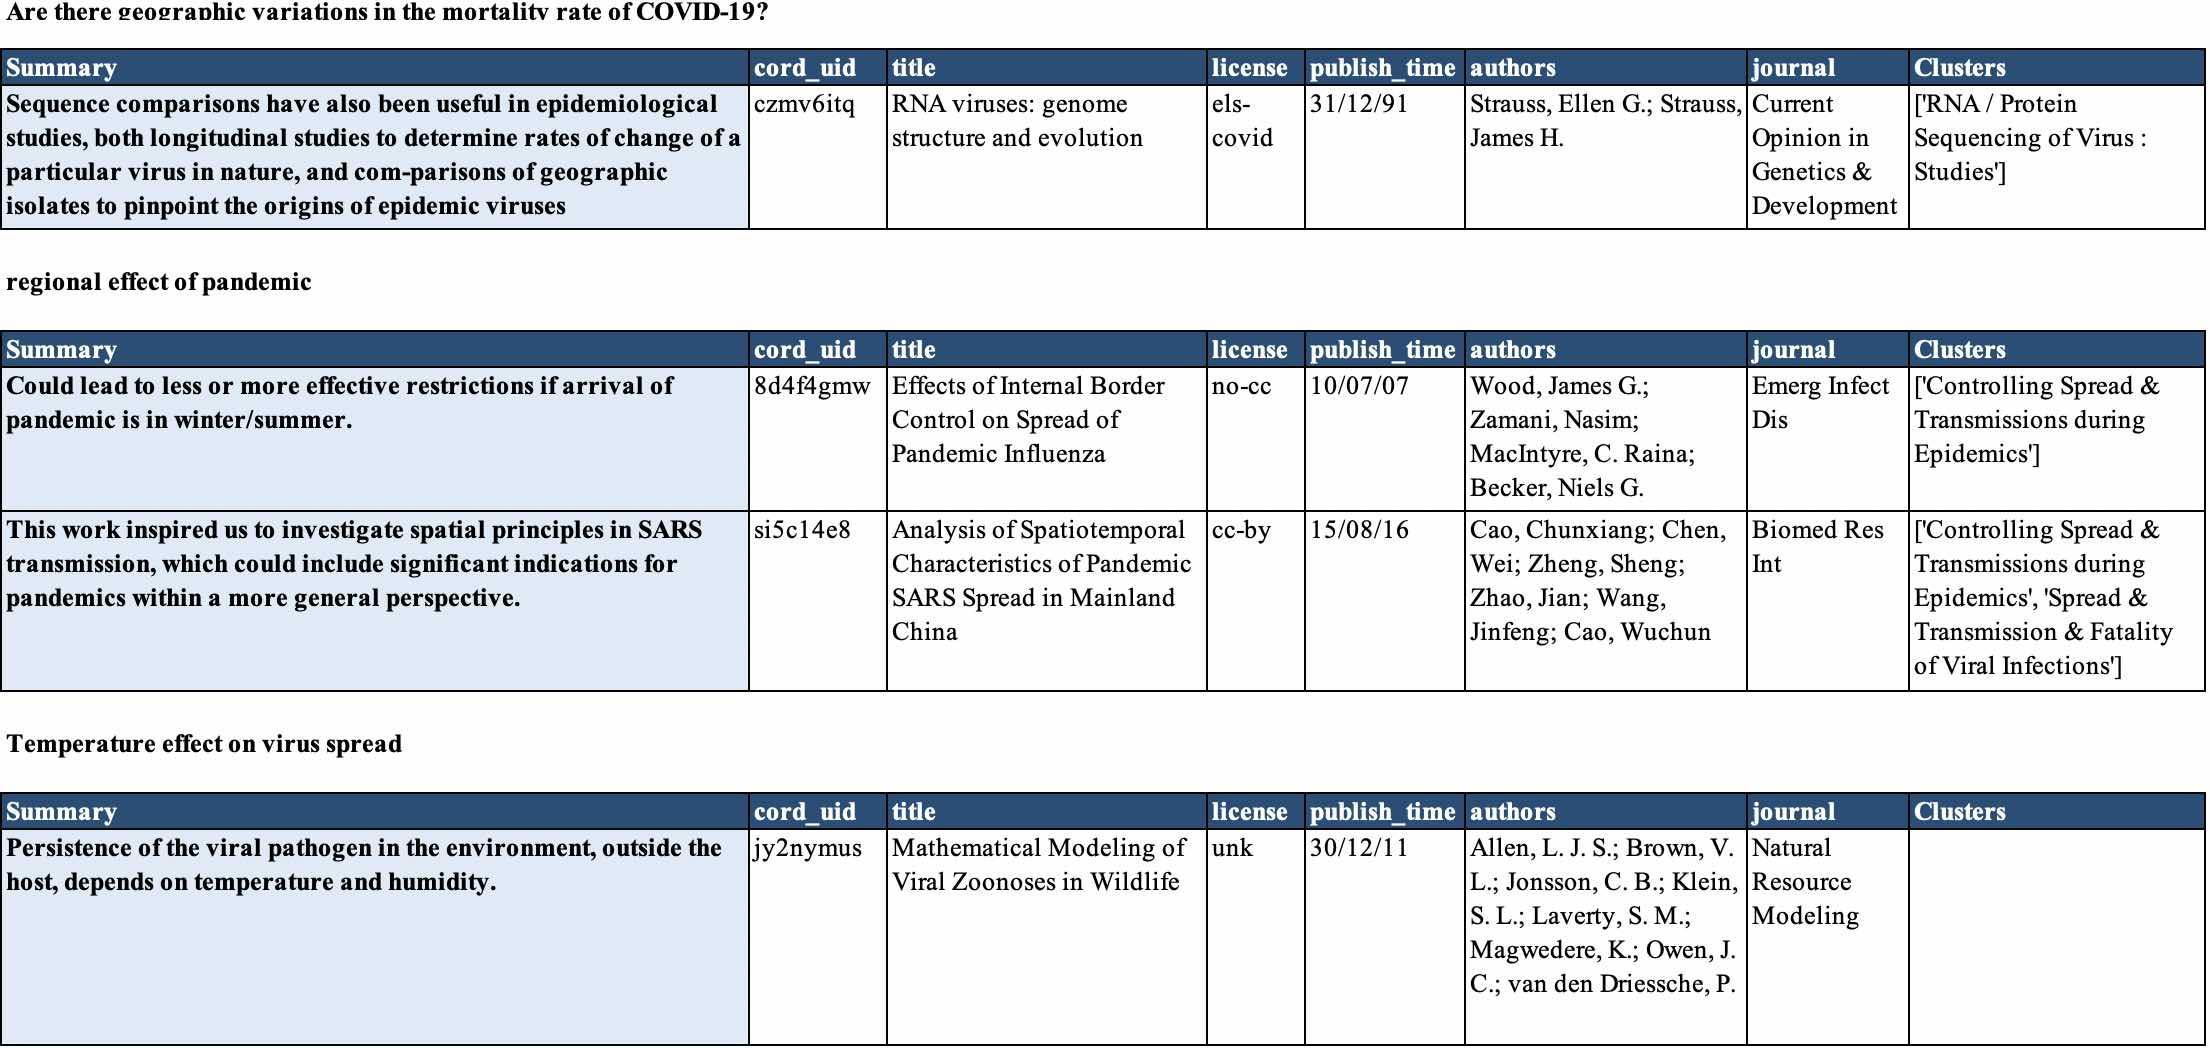

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import subprocess
import pickle
import ast

import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import subprocess
import pickle
import ast
import numpy as np
import io
from sklearn.metrics.pairwise import cosine_similarity
import re
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pprint
import matplotlib.pyplot as plt
import pickle as pkl
!pip install biobert-embedding
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from scipy.spatial import distance
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
def preprocess_sentence(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

    return ' '.join(tokens)
from nltk import tokenize
from IPython.display import display, HTML

# Import package and change code to run on GPU




In [ ]:
from biobert_embedding.embedding import BiobertEmbedding
import os
import torch
import logging
import tensorflow as tf
from pathlib import Path
from biobert_embedding import downloader
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
logging.basicConfig(filename='app.log', filemode='w',format='%(asctime)s %(message)s', level=logging.INFO)

logger = logging.getLogger(__name__)
class BiobertEmbedding(object):
    """
    Encoding from BioBERT model (BERT finetuned on PubMed articles).
    Parameters
    ----------
    model : str, default Biobert.
            pre-trained BERT model
    """

    def __init__(self, model_path=None):

        if model_path is not None:
            self.model_path = model_path
        else:
            self.model_path = downloader.get_BioBert("google drive")

        self.tokens = ""
        self.sentence_tokens = ""
        self.tokenizer = BertTokenizer.from_pretrained(self.model_path)
        # Load pre-trained model (weights)
        self.model = BertModel.from_pretrained(self.model_path)
        self.model.to(device)
        logger.info("Initialization Done !!")

    def process_text(self, text):

        marked_text = "[CLS] " + text + " [SEP]"
        # Tokenize our sentence with the BERT tokenizer.
        tokenized_text = self.tokenizer.tokenize(marked_text)
        return tokenized_text


    def handle_oov(self, tokenized_text, word_embeddings):
        embeddings = []
        tokens = []
        oov_len = 1
        for token,word_embedding in zip(tokenized_text, word_embeddings):
            if token.startswith('##'):
                token = token[2:]
                tokens[-1] += token
                oov_len += 1
                embeddings[-1] += word_embedding
            else:
                if oov_len > 1:
                    embeddings[-1] /= oov_len
                tokens.append(token)
                embeddings.append(word_embedding)
        return tokens,embeddings


    def eval_fwdprop_biobert(self, tokenized_text):

        # Mark each of the tokens as belonging to sentence "1".
        segments_ids = [1] * len(tokenized_text)
        # Map the token strings to their vocabulary indeces.
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)

        # Convert inputs to PyTorch tensors
        tokens_tensor = torch.tensor([indexed_tokens]).to(device)
        segments_tensors = torch.tensor([segments_ids]).to(device)

        # Put the model in "evaluation" mode, meaning feed-forward operation.
        self.model.eval()
        # Predict hidden states features for each layer
        with torch.no_grad():
            encoded_layers, _ = self.model(tokens_tensor, segments_tensors)

        return encoded_layers


    def word_vector(self, text, handle_oov=True, filter_extra_tokens=True):

        tokenized_text = self.process_text(text)

        encoded_layers = self.eval_fwdprop_biobert(tokenized_text)

        # Concatenate the tensors for all layers. We use `stack` here to
        # create a new dimension in the tensor.
        token_embeddings = torch.stack(encoded_layers, dim=0)
        token_embeddings = torch.squeeze(token_embeddings, dim=1)
        # Swap dimensions 0 and 1.
        token_embeddings = token_embeddings.permute(1,0,2)

        # Stores the token vectors, with shape [22 x 768]
        word_embeddings = []
        logger.info("Summing last 4 layers for each token")
        # For each token in the sentence...
        for token in token_embeddings:

            # `token` is a [12 x 768] tensor
            # Sum the vectors from the last four layers.
            sum_vec = torch.sum(token[-4:], dim=0)

            # Use `sum_vec` to represent `token`.
            word_embeddings.append(sum_vec)

        self.tokens = tokenized_text
        if filter_extra_tokens:
            # filter_spec_tokens: filter [CLS], [SEP] tokens.
            word_embeddings = word_embeddings[1:-1]
            self.tokens = tokenized_text[1:-1]

        if handle_oov:
            self.tokens, word_embeddings = self.handle_oov(self.tokens,word_embeddings)
        logger.info(self.tokens)
        logger.info("Shape of Word Embeddings = %s",str(len(word_embeddings)))
        return word_embeddings



    def sentence_vector(self,text):

        logger.info("Taking last layer embedding of each word.")
        logger.info("Mean of all words for sentence embedding.")
        tokenized_text = self.process_text(text)
        self.sentence_tokens = tokenized_text
        encoded_layers = self.eval_fwdprop_biobert(tokenized_text)

        # `encoded_layers` has shape [12 x 1 x 22 x 768]
        # `token_vecs` is a tensor with shape [22 x 768]
        token_vecs = encoded_layers[11][0]

        # Calculate the average of all 22 token vectors.
        sentence_embedding = torch.mean(token_vecs, dim=0)
        logger.info("Shape of Sentence Embeddings = %s",str(len(sentence_embedding)))
        return sentence_embedding


# Check GPU

In [ ]:
device.type

# Sentence transformer

In [ ]:
pip install -U sentence-transformers

# Download BioBert

In [ ]:
model_path = downloader.get_BioBert("google drive")

# Testing BiobertEmbedding

In [ ]:
text = "Breast cancers with HER2 amplification have a higher risk of CNS metastasis and poorer prognosis."\

# Class Initialization (You can set default 'model_path=None' as your finetuned BERT model path while Initialization)
biobert = BiobertEmbedding(model_path)

word_embeddings = biobert.word_vector(text)
sentence_embedding = biobert.sentence_vector(text)

print("Text Tokens: ", biobert.tokens)
# Text Tokens:  ['breast', 'cancers', 'with', 'her2', 'amplification', 'have', 'a', 'higher', 'risk', 'of', 'cns', 'metastasis', 'and', 'poorer', 'prognosis', '.']

print ('Shape of Word Embeddings: %d x %d' % (len(word_embeddings), len(word_embeddings[0])))
# Shape of Word Embeddings: 16 x 768

print("Shape of Sentence Embedding = ",len(sentence_embedding))
# Shape of Sentence Embedding =  768

# Testing SentenceTransformer

In [ ]:
# Use BERT for mapping tokens to embeddings
from sentence_transformers import models
from sentence_transformers import SentenceTransformer
word_embedding_model = models.BERT('/kaggle/working/'+model_path.name)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=True,
                               pooling_mode_max_tokens=True)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [ ]:
from sentence_transformers import SentenceTransformer

sentence_embeddings = model.encode([text])
print("Shape of Sentence Embedding = ",len(sentence_embedding))

# Read papers Selected for Task
Order of tasks have been changed based on popularity. When we prepared subqueries, summaries and QA, it was task-8. Using old nomenclature for files. (Currently it is at 7)

In [ ]:
Task='Task 08'
data=pd.read_excel("/kaggle/input/task3covid/task8_results_summary.xlsx")

qadata=pd.read_excel("/kaggle/input/covid-task-qa-answer/task8_results_summary_QA.xlsx")
paper_cluster_mapping=pd.read_excel("/kaggle/input/task1-results/archive (2)/Final_Clusters_Keywords_UID.xlsx")
Query_Mapping=pd.read_excel("/kaggle/input/covid19-task-query/Covid19_tasks_subtask_query.xlsx")
qadata=qadata.rename({'Subtask mapping':'Subtask'},axis=1)
Query_Mapping=Query_Mapping.rename({'Queries ':'Queries'},axis=1)
Look_up=Query_Mapping[Query_Mapping['Task'].str.contains(Task)].merge(qadata,on=['Queries','Subtask'],how='left').reset_index(drop=True)
paper_cluster_mapping_lookup=paper_cluster_mapping[~(paper_cluster_mapping.Cluster_Names.isna())].groupby('cord_uid')['Cluster_Names'].apply(list).reset_index(name='Clusters')
paper_cluster_mapping_de_Dupe=paper_cluster_mapping.drop_duplicates('cord_uid')
metadata=pd.read_csv("/kaggle/input/CORD-19-research-challenge/metadata.csv")
metadata=metadata.drop_duplicates('cord_uid')
qadata['Context_Answer']=qadata['answer-summary(+/-50 chars)'].apply(lambda x:x.split(" ", 1)[1])
qadata=qadata.drop('title',axis=1).merge(metadata,on=['cord_uid'],how='left')
qadata.Clusters=qadata.Clusters.apply(lambda x : ast.literal_eval(x))
qadata=qadata.rename({'answer-summary':'answer'},axis=1)

# Data cleaning

In [ ]:
meta_df_title_abstract=data
len1=meta_df_title_abstract.shape[0]
list1=list(range(len1))
meta_df_title_abstract['pid']=list1
meta_df_title_abstract.head()
meta_df_title_abstract['summary_preprocessed']=meta_df_title_abstract['Text'].apply(lambda x:tokenize.sent_tokenize(x))
new_data_sent=meta_df_title_abstract['summary_preprocessed'].apply(pd.Series).reset_index().melt(id_vars='index').dropna()[['index', 'value']].set_index('index')
new_data_sent=new_data_sent.merge(meta_df_title_abstract[['cord_uid', 'lsid', 'gsid', 'Name', 'Text', 'Subtype', 'summary', 'pid']],right_index=True,left_index=True,how='left')
new_data_sent['wrd_cnt']=new_data_sent['value'].str.split().str.len()
new_data_sent_strip=new_data_sent[new_data_sent['wrd_cnt']>6]
print("wrd cnt > 6 " + str(new_data_sent.shape))
new_data_sent_strip=new_data_sent_strip[new_data_sent_strip['wrd_cnt']<100]
print("wrd cnt < 200 " + str(new_data_sent_strip.shape))
new_data_sent_strip['value_edit']=new_data_sent_strip['value'].apply(lambda x:preprocess_sentence(x))

# embedding function for Biobert on CPU and GPU

In [ ]:
def get_bert_embedding(wr):
    #try :
    return biobert.sentence_vector(wr).cpu()

def get_sent_bert_embedding(wr):
    #try :
    return model.encode([wr],show_progress_bar=False)

from concurrent.futures import ThreadPoolExecutor
import time
def process_on_set(files, num_workers,function):
    def process_file(i):
        filename_2 = files[i]

        y_pred = function(filename_2)
        return y_pred

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        predictions = ex.map(process_file, range(len(files)))

    return list(predictions)

#xt=new_data_sent_strip['value_edit'].head().apply(lambda x:chk_len(x))

# Testing Speed

In [ ]:

%%time
print(device.type)
if device.type=='cuda':
    xt=new_data_sent_strip['value_edit'].head(1000).apply(lambda x:get_sent_bert_embedding(x))   
else:
    xt = process_on_set(new_data_sent_strip['value_edit'].head(1000).values,4,get_bert_embedding)

In [ ]:
%%time
print(device.type)
if device.type=='cuda':
    xt=new_data_sent_strip['value_edit'].head(1000).apply(lambda x:get_bert_embedding(x))   
else:
    xt = process_on_set(new_data_sent_strip['value_edit'].head(1000).values,4,get_bert_embedding)

# Working using sentence transformer for speed and polling selection

## Generate embedding for each line
#### Automatic use parallel processing if GPU is unavailable

In [ ]:
%%time
print(device.type)
if device.type=='cuda':
    xt=new_data_sent_strip['value_edit'].apply(lambda x:get_sent_bert_embedding(x))   
else:
    xt = process_on_set(new_data_sent_strip['value_edit'].values,4,get_bert_embedding)
new_data_sent_strip['Embedding']=xt
import pickle
with open('/kaggle/working/embeddings37912.pickle', 'wb') as handle:
    pickle.dump(new_data_sent_strip, handle)
new_data_sent_strip.to_csv("new_data_sent_strip.csv",index=False)

In [ ]:

query_embedding_sent_df=new_data_sent_strip.copy()
Comp_reserch_data=pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv')

# Code for Search and page rank

In [ ]:
def prepare_dataset(df,query,query_id=0,val=0.9):
    #print("Query is ")
    #print(query_text[query_id])
    query_embedding_sent_df['match']=df['Embedding'].apply(lambda x:cosine_similarity(x[0].reshape(1,x[0].shape[0]),query[query_id].reshape(1,query[query_id].shape[0]))[0][0])
    shape_val=0
    while shape_val<100:
        query_embedding_sent_df_subset=query_embedding_sent_df[query_embedding_sent_df['match']>val]
        val=val-0.02
        shape_val=query_embedding_sent_df_subset.shape[0]
    original_sentences=query_embedding_sent_df_subset.value.values
    sentence_vectors=query_embedding_sent_df_subset.Embedding.values
    cord_uid=query_embedding_sent_df_subset.cord_uid.values
    #print('Total Sentence := ' + str (sentence_vectors.shape[0]))
    sentence_vectors_all=[sentence_vectors[k][0] for k in range(sentence_vectors.shape[0])]
    sim_matrix = cosine_similarity(np.array(sentence_vectors_all))
    #print(np.mean(sim_matrix))
    sim_matrix_thresh = np.where(sim_matrix > np.mean(sim_matrix), sim_matrix, 0)
    return sim_matrix_thresh,original_sentences,cord_uid


def print_diffmethod(function,name,original_sentences,cord_uid):
#     print(str(name))
    page_rank_result = pd.DataFrame({'sentence_index':list(function.keys()), 'score':list(function.values()), 
                                    'original_sentence':original_sentences,'cord_uid':cord_uid})
    page_rank_result['key']=page_rank_result.original_sentence.str.replace(" ","")
    page_rank_result=page_rank_result.drop_duplicates(['key'])
#     page_rank_result.nlargest(10, 'score')
#     for s in page_rank_result.nlargest(7, 'score')['original_sentence']:
#         pprint.pprint(s)
#         pprint.pprint('-------------------------------------------------------------------------------------')
#     pprint.pprint("-"*40)
    return page_rank_result[['score','original_sentence','cord_uid']]



# Search and results code
** Find best sentence for query**

In [ ]:
def print_summary(query_i_text='What are risk reduction strategies?'):
    query_i_embed=model.encode([query_i_text],show_progress_bar=False)

    sim_matrix_thresh,original_sentences,cord_uid=prepare_dataset(df=query_embedding_sent_df,query=query_i_embed,query_id=0,val=0.99)
    G = nx.Graph(sim_matrix_thresh)
    nx.pagerank(G)
    #nx.draw_networkx(G)
    t=print_diffmethod(nx.pagerank(G),'Pagerank',original_sentences,cord_uid)
    #all_search=all_search.merge(paper_cluster_mapping_lookup,on='cord_uid',how='left').fillna('')
    all_search=t.nlargest(7, 'score').merge(Comp_reserch_data[['cord_uid',  'title', 'license', 'publish_time', 'authors', 'journal']],on=['cord_uid'],how='inner')
    all_search=all_search.merge(paper_cluster_mapping_lookup,on='cord_uid',how='left').fillna('')
    
    display(HTML('<font size="4" color="blue"> <b> Specific question subtask Query Searched : </b> </font><p> <font size="4">'+query_i_text+'</font><p>'))

    #display(HTML(all_search.to_html()))
    display(HTML(all_search.rename({'original_sentence':'Summary'},axis=1).style.set_properties(subset=['Summary'], \
                                         **{'font-weight': 'bold','font-size': '12pt','text-align':"left",'background-color': 'lightgrey','color': 'black'}).set_table_styles(\
                                         [dict(selector='th', props=[('text-align', 'left'),('font-size', '12pt'),('background-color', 'pink'),('border-style','solid'),('border-width','1px')])]).hide_index().render()))

    display(HTML("-------End-----"*15))
def cluster_sentence(query_i_text='What are risk reduction strategies?'):
    query_i_embed=model.encode([query_i_text],show_progress_bar=False)

    sim_matrix_thresh,original_sentences,cord_uid=prepare_dataset(df=query_embedding_sent_df,query=query_i_embed,query_id=0,val=0.99)
    G = nx.Graph(sim_matrix_thresh)
    nx.pagerank(G)
    #nx.draw_networkx(G)
    t=print_diffmethod(nx.pagerank(G),'Pagerank',original_sentences,cord_uid)

    all_search=t.nlargest(7, 'score').merge(Comp_reserch_data[['cord_uid',  'title', 'license', 'publish_time', 'authors', 'journal']],on=['cord_uid'],how='inner')
    all_search=all_search.merge(paper_cluster_mapping_lookup,on='cord_uid',how='left').fillna('')
    return all_search.Clusters.explode().values
def print_qa_bot(quer='What are risk reduction strategies?'):
    result=qadata[qadata['Question form of queries']==quer][[ 'answer','Context_Answer','Clusters','cord_uid',  'title', 'license', 'publish_time', 'authors', 'journal']]
    display(HTML(result.style.set_properties(subset=['answer'], \
                                                 **{'font-weight': 'bold','font-size': '12pt','text-align':"left",'background-color': 'lightgrey','color': 'black'}).set_table_styles(\
                                                 [dict(selector='th', props=[('text-align', 'left'),('font-size', '12pt'),('background-color', 'pink'),('border-style','solid'),('border-width','1px')])]).hide_index().render()))


def cluster_qa(query_i_text='What are risk reduction strategies?'):
    result=qadata[qadata['Question form of queries']==query_i_text][[ 'answer','Context_Answer','Clusters','cord_uid',  'title', 'license', 'publish_time', 'authors', 'journal']]

    return result.Clusters.explode().values
def print_clusters(clusters):
    u, count = np.unique(clusters, return_counts=True)

    count_sort_ind = np.argsort(-count)
    display(HTML('<font size="3" color="black"> <b> Cluster Name :</b> </font>' ))
    for x in zip(u[count_sort_ind],count[count_sort_ind]):
        
        if x[0] != '':
            display(HTML("Cluster name is " +str(x[0])+" Count:- " +str(x[1])))


# All results for Task

In [ ]:
query_embedding_sent_df=query_embedding_sent_df.merge(paper_cluster_mapping_lookup,on='cord_uid',how='left').fillna('')
query_embedding_sent_df
for Subtask in Look_up.Subtask.unique():
    display(HTML('<font size="6" color="black"> <b> Subtask Searched : </b> </font><p> <font size="4">'+Subtask+'</font><p>'))
    Query_Mapping_Task_query=Look_up[Look_up['Subtask']==Subtask].reset_index(drop=True)

    for Queries in Query_Mapping_Task_query['Queries'].unique():
        quer=qadata[(qadata['Queries']==Queries.strip()) & (qadata['Subtask']==Subtask)]['Question form of queries'].drop_duplicates().values.tolist()

        if len(quer)>0:
            display(HTML('<font size="4" color="blue"> <b> Top Reserch Clusters : Query </b> </font><p> <font size="4">'+quer[0]+'</font><p>'))
            cluster_sen=cluster_sentence(quer[0])
            cluster_qaq=cluster_qa(quer[0])
            cluster=np.array(cluster_sen.tolist()+cluster_qaq.tolist())
        else :
            display(HTML('<font size="4" color="blue"> <b> Top Reserch Clusters : Query </b> </font><p> <font size="4">'+Queries+'</font><p>'))
            cluster_sen=cluster_sentence(Queries)
            cluster=np.array(cluster_sen.tolist())
        print_clusters(cluster)
        

        
        if len(quer)>0:
            
            display(HTML('<font size="4" color="blue"> <b> Q&A Top Reserch Clusters : Query </b> </font><p> <font size="4">'+quer[0]+'</font><p>'))
            print_clusters(cluster_qaq)
            display(HTML('<font size="4" color="blue"> <b> Top Reserch Q&A : </b> </font><p> <font size="4">'+'</font><p>'))
            print_qa_bot(quer[0])
        if len(quer)>0:
            
            display(HTML('<font size="4" color="blue"> <b> Sentence Top Reserch Clusters : Query</b> </font><p> <font size="4">'+quer[0]+'</font><p>'))
            print_clusters(cluster_sen)
            display(HTML('<font size="4" color="blue"> <b> Top Reserch Sentence : </b> </font><p> <font size="4">'+'</font><p>'))
            print_summary(quer[0])
        else :
            
            display(HTML('<font size="4" color="blue"> <b> Sentence Top Reserch Clusters : Query</b> </font><p> <font size="4">'+Queries+'</font><p>'))
            print_clusters(cluster_sen)
            display(HTML('<font size="4" color="blue"> <b> Top Reserch Sentence : </b> </font><p> <font size="4">'+'</font><p>'))
            print_summary(Queries)

    